In [1]:
import torch
import open_clip
import os
import numpy as np
import faiss
import json
from PIL import Image
import matplotlib.pyplot as plt
import pytesseract
import easyocr



/opt/anaconda3/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
import pickle

with open("meme_database.pkl", "rb") as f:
    data = pickle.load(f)

print(type(data))  # Should be a list or dictionary
print(data)  # See the actual content


FileNotFoundError: [Errno 2] No such file or directory: 'meme_database.pkl'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_tuple = open_clip.create_model_and_transforms("ViT-B/32", pretrained="openai")


/opt/anaconda3/lib/python3.12/site-packages/open_clip/factory.py:388: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(


In [3]:
model = model_tuple[0]
preprocess = model_tuple[1]

In [4]:
model.to(device)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine

In [ ]:
tokenizer = open_clip.get_tokenizer("ViT-B-32")

In [11]:
meme_folder = "memes/"

meme_data=[]

def store_memes():
    global index
    for idx, filename in enumerate(os.listdir(meme_folder)):
        if filename.endswith((".jpg", ".jpeg", ".png")):
            image_path = os.path.join(meme_folder, filename)
            img = Image.open(image_path)

            # Extract text using OCR
            reader = easyocr.Reader(['en'])
            extracted_text = reader.readtext(image_path, detail = 0)

            caption = " ".join(extracted_text) 

            # Store meme details
            meme_data.append({"id": idx + 1, "file": filename, "caption": caption})

    meme_vectors = []
    for meme in meme_data:
        image = preprocess(Image.open(os.path.join(meme_folder, meme["file"]))).unsqueeze(0).to(device)
        text = open_clip.tokenize([meme["caption"]]).to(device)

        with torch.no_grad():
            image_embedding = model.encode_image(image)
            text_embedding = model.encode_text(text)

        meme_embedding = (image_embedding+text_embedding)/2
        meme_vectors.append(meme_embedding.cpu().numpy())

    meme_vectors

        # Convert list of arrays into a single NumPy array
    meme_vectors = np.vstack(meme_vectors)

    # Create FAISS index

    index = faiss.IndexFlatL2(meme_vectors.shape[1])
    index.add(meme_vectors)

    faiss.write_index(index, "meme_index.faiss")
    with open("memes.json","w") as f:
        json.dump(meme_data,f)



In [12]:
store_memes()

In [15]:
app = FastAPI()

NameError: name 'FastAPI' is not defined

In [14]:
@app.get("/search")
def find_best_meme(prompt):
    text_embedding = model.encode_text(open_clip.tokenize([prompt]).to(device)).detach().cpu().numpy()
    _, best_match_idx = index.search(text_embedding, 1)
    best_meme = meme_data[best_match_idx[0][0]]
    
    return best_meme

NameError: name 'app' is not defined

In [135]:
def show_meme(meme):
    image_path = os.path.join(meme_folder, meme["file"])  # Get full path to meme image
    image = Image.open(image_path)  # Open the image
    
    # Display the image with caption
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis("off")  # Hide axes
    plt.title(meme["caption"], fontsize=12, wrap=True)  # Show caption as title
    plt.show()

Best meme: 🏊_♀️.jpeg - theyhate when yoU serve weird older sister who slays andis kind of unstable


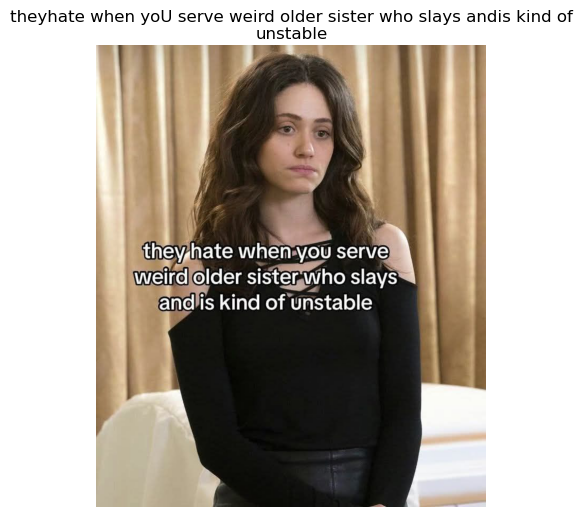

In [169]:
user_prompt = "oldest daughter"
best_meme = find_best_meme(user_prompt)
print(f"Best meme: {best_meme['file']} - {best_meme['caption']}")
show_meme(best_meme)  